# <center>COMPUTAÇÃO GRÁFICA - Trabalho Prático 1: Processamento de Dados Geométricos utilizando Python e PyQt</center>

<i>João Duarte Colares & Patrick Duarte Pimenta</i>

## <center>Objetivo</center>

O objetivo deste trabalho é desenvolver um programa em Python que processe dados geométricos descritos de um arquivo XML. Para tal finalidade, será utilizando a biblioteca gráfica PyQt para exibir graficamente os objetos geométricos e desta forma gerar um novo arquivo com os dados dos objetos transformados para um 
sistema de coordenadas específico.

## <center>Implementação</center>

A implementação do programa será dividida em duas partes principais:

1. **Processamento dos dados:** Leitura do arquivo XML de entrada, transformação dos dados dos objetos geométricos, adição de margem à viewport, inversão da coordenada y.

2. **Interface Gráfica:** Utilização da biblioteca PyQt para exibir graficamente os objetos geométricos em uma janela.

## <center>Descrição do Trabalho</center>

1. **Leitura do arquivo XML de entrada:** O programa deve ser capaz de ler um arquivo XML de entrada chamado "entrada.xml", que conterá informações sobre os objetos geométricos a serem processados. Este arquivo terá a seguinte estrutura:

<?xml version="1.0" ?>
<!-- comentários... -->
<dados>
	<viewport>
		<!-- viewport para uma janela de visualização de 620x460 com margem de  10pixels (area total de 640x480)-->
		<vpmin x="10" y="10"/>
		<vpmax x="630" y="470"/>
	</viewport>
	
	<window>
		<wmin x="0.0" y="0.0"/>
		<wmax x="10.0" y="10.0"/>
	</window>

	<ponto x="0" y="2"/>
	<ponto x="2" y="4"/>
	<ponto x="4" y="6"/>

	<reta>
		<ponto x="2" y="2"/>
		<ponto x="4" y="4"/>
	</reta>

	<reta>
		<ponto x="4" y="4"/>
		<ponto x="2" y="6"/>
	</reta>

	<poligono>
		<ponto x="1.0" y="1.0"/>
		<ponto x="1.0" y="2.0"/>
		<ponto x="2.0" y="2.0"/>
		<ponto x="2.0" y="1.0"/>
		<!-- <ponto> adicionais -->
	</poligono>
</dados>

In [1]:
# Importação das bibliotecas
import sys
import re
import xml.etree.ElementTree as ET
from random import randint
from PyQt6 import QtCore, QtGui, QtWidgets, uic
from PyQt6.QtCore import Qt
from PyQt6.QtWidgets import QApplication
from IPython.display import Image

2. **Transformação para o sistema de coordenadas da viewport:** Os dados dos objetos geométricos devem ser transformados do sistema de coordenadas da window para o sistema de coordenadas da viewport. Isso envolve a aplicação de uma escala e transladação para ajustar as coordenadas dos objetos.

In [2]:
# Definindo as classes para representar os objetos geométricos
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Reta:
    def __init__(self, Ponto1, Ponto2):
        self.ponto1 = Ponto1
        self.ponto2 = Ponto2

class Poligono:

    def __init__(self,pontos):
        self.pontos = []
        tamanho = len(pontos)
        i = 0
        while(i<tamanho):
            self.pontos.append(pontos[i])
            i+=1

In [3]:
#transforma um ponto
def transformar_ponto(coordenada, window, viewport):
    xwmin, ywmin = window[0].x, window[0].y
    xwmax, ywmax = window[1].x, window[1].y
    xvmin, yvmin = viewport[0].x, viewport[0].y
    xvmax, yvmax = viewport[1].x, viewport[1].y

    xv = xvmin + (coordenada.x - xwmin) * (xvmax - xvmin) / (xwmax - xwmin)
    yv = yvmin + (coordenada.y - ywmin) * (yvmax - yvmin) / (ywmax - ywmin)

    return Ponto(xv, yv)

# Função para transformar os pontos para o sistema de coordenadas da viewport com a margem e o y invertido
def transformar(pontos,retas,poligono,window,viewport):
    viewport_x = int(viewport[1].x) - int(viewport[0].x)
    viewport_y = int(viewport[1].y) - int(viewport[0].y)

    window_x = int(window[1].x) - int(window[0].x)
    window_y = int(window[1].y) - int(window[0].y)

    largura = viewport_x / window_x
    altura = viewport_y / window_y

    margem_y = int(viewport[0].y)
    margem_x = int(viewport[0].x)



    # Aplicando a transformação nos pontos
    for ponto in pontos:
        ponto.x = (int(ponto.x) * largura) + margem_x
        ponto.y = int(viewport_y) - ((int(ponto.y) * altura)) + margem_y

    # Aplicando a transformação nas retas
    for reta in retas:
        reta.ponto1.x = (int(reta.ponto1.x) * largura) + margem_x
        reta.ponto2.x = (int(reta.ponto2.x) * largura) + margem_x
        reta.ponto1.y = int(viewport_y) - ((int(reta.ponto1.y) * altura)) + margem_y
        reta.ponto2.y = int(viewport_y) - ((int(reta.ponto2.y) * altura)) + margem_y

    # Aplicando a transformação no polígono
    for ponto in poligono:
        ponto.x = (int(ponto.x) * largura) + margem_x
        ponto.y = int(viewport_y) - ((int(ponto.y) * altura)) + margem_y

    # Atualizando os limites da window para os da viewport
    window[0].x = 0
    window[0].y = 0
    window[1].x = viewport_x + margem_x
    window[1].y = viewport_y + margem_y


3. **Adição de margem à viewport:** Uma margem de 10 pixels deve ser adicionada à viewport em todas as direções (acima, abaixo, à esquerda e à direita).

In [4]:
# Função para adicionar margem à viewport
def adicionar_margem(window, viewport, pontos, retas, poligono):
    margem_y = int(viewport[0].y)
    margem_x = int(viewport[0].x)

    # Adicionando margem acima e abaixo
    window[1].y = window[1].y + margem_y * 2

    for ponto in pontos:
        ponto.y = ponto.y + margem_y

    for reta in retas:
        reta.ponto1.y = reta.ponto1.y + margem_y
        reta.ponto2.y = reta.ponto2.y + margem_y

    for ponto in poligono:
        ponto.y = ponto.y + margem_y

    # Adicionando margem à esquerda e à direita
    window[1].x = window[1].x + margem_x * 2

    for ponto in pontos:
        ponto.x = ponto.x + margem_x

    for reta in retas:
        reta.ponto1.x = reta.ponto1.x + margem_x
        reta.ponto2.x = reta.ponto2.x + margem_x

    for ponto in poligono:
        ponto.x = ponto.x + margem_x

4. **Inversão da coordenada y:** A coordenada y dos objetos deve ser invertida, pois o sistema de coordenadas da viewport tem a origem no canto superior esquerdo.

In [5]:
# Função para inverter a coordenada y
def inverter_y(window, pontos, retas, poligono):
    for ponto in pontos:
        ponto.y = window[1].y - ponto.y

    for reta in retas:
        reta.ponto1.y = window[1].y - reta.ponto1.y
        reta.ponto2.y = window[1].y - reta.ponto2.y

    for ponto in poligono:
        ponto.y = window[1].y - ponto.y

5. **Exibição gráfica dos objetos:** Utilizando a biblioteca PyQt, os objetos geométricos devem ser exibidos graficamente em uma janela.

In [6]:
# Classe para a janela principal da aplicação
class MainWindow(QtWidgets.QMainWindow):
    def __init__(self, pontos, retas, poligono, window_x, window_y):
        super().__init__()

        self.label = QtWidgets.QLabel()
        canvas = QtGui.QPixmap(window_x, window_y)
        canvas.fill(Qt.GlobalColor.white)
        self.label.setPixmap(canvas)
        self.setCentralWidget(self.label)
        self.draw_something()

        self.pontos = pontos
        self.retas = retas
        self.poligono = poligono

    # Método para desenhar os objetos na tela
    def draw_something(self):
        canvas = self.label.pixmap()
        painter = QtGui.QPainter(canvas)

        pen = QtGui.QPen()
        pen.setColor(QtGui.QColor('gray'))

        painter.setPen(pen)

        # Desenhando grade de fundo
        for i in range(100):
            painter.drawLine(0, i * 10, 1000, i * 10)

        for i in range(100):
            painter.drawLine(i * 10, 0, i * 10, 1000)

        pen.setColor(QtGui.QColor('black'))
        painter.setPen(pen)

        # Desenhando os pontos na tela
        for ponto in pontos:
            painter.drawPoint(int(ponto.x), int(ponto.y))

        # Desenhando as retas na tela
        for reta in retas:
            painter.drawLine(int(reta.ponto1.x), int(reta.ponto1.y), int(reta.ponto2.x), int(reta.ponto2.y))

        # Desenhando o polígono na tela
        i = 0
        while(i < (len(poligono) - 1)):
            painter.drawLine(int(poligono[i].x), int(poligono[i].y), int(poligono[i + 1].x), int(poligono[i + 1].y))
            i += 1

        painter.drawLine(int(poligono[i].x), int(poligono[i].y), int(poligono[0].x), int(poligono[0].y))

        painter.end()
        self.label.setPixmap(canvas)

In [7]:
# Função para capturar a tela da aplicação e salvar como uma imagem
def salvar_imagem(window, nome_arquivo):
    screenshot = window.grab()  # Captura a tela da janela
    screenshot.save(nome_arquivo)  # Salva a captura como uma imagem

In [8]:
# Parsing do arquivo XML de entrada
tree = ET.parse('entrada.xml')
root = tree.getroot()

e = root[0][1].text

# Imprimindo a tag da raiz
print(root.tag)

# Listas para armazenar os pontos, retas e polígono
pontos = []
retas = []
poligono = []

viewport = []
window = []

dados


In [9]:
# Iterando sobre os elementos do XML
for child in root:
    if (child.tag == 'viewport'):
        for child01 in child:
            if((child01.tag == 'vpmin') or (child01.tag == 'vpmax')):
                resultados = re.findall(r'\d+', str(child01.attrib))
                viewport.append(Ponto(resultados[0], resultados[1]))

    elif(child.tag == 'window'):
        for child02 in child:
            resultados = re.findall(r'\d+', str(child02.attrib))
            window.append(Ponto(resultados[0], resultados[2]))

    elif (child.tag == 'ponto'):
        resultados = re.findall(r'\d+', str(child.attrib))
        pontos.append(Ponto(resultados[0], resultados[1]))

    elif (child.tag == 'reta'):
        pontos_da_reta =[]
        for child2 in child:
            resultados = re.findall(r'\d+', str(child2.attrib))
            pontos_da_reta.append(Ponto(resultados[0], resultados[1]))
        retas.append(Reta(pontos_da_reta[0], pontos_da_reta[1]))

    elif (child.tag == 'poligono'):
        for child3 in child:
            resultados = re.findall(r'\d+', str(child3.attrib))
            poligono.append(Ponto(resultados[0], resultados[2]))

In [10]:
# Imprimindo os pontos, retas, viewport e window antes da transformação
print('pontos: ')
for ponto in pontos:
    print('coordenadas do ponto:')
    print(ponto.x)
    print(ponto.y)

for reta in retas:
    print('pontos da reta:')
    print('ponto 1 da reta: ')
    print(reta.ponto1.x)
    print(reta.ponto1.y)
    print('ponto 2 da reta: ')
    print(reta.ponto2.x)
    print(reta.ponto2.y)
    print('')

print('pontos do polígono: ')
for pontos2 in poligono:
    print('ponto: ')
    print(pontos2.x)
    print(pontos2.y)

print('viewport: ')
print(viewport[0].x)
print(viewport[0].y)
print('')
print(viewport[1].x)
print(viewport[1].y)

print('window: ')
print(window[0].x)
print(window[0].y)
print('')
print(window[1].x)
print(window[1].y)

pontos: 
coordenadas do ponto:
0
2
coordenadas do ponto:
2
4
coordenadas do ponto:
4
6
pontos da reta:
ponto 1 da reta: 
2
2
ponto 2 da reta: 
4
4

pontos da reta:
ponto 1 da reta: 
4
4
ponto 2 da reta: 
2
6

pontos do polígono: 
ponto: 
1
1
ponto: 
1
2
ponto: 
2
2
ponto: 
2
1
viewport: 
10
10

630
470
window: 
0
0

10
10


In [11]:
#classe polígono
poligono2 = Poligono(pontos)

# Transformando os objetos para o sistema de coordenadas da viewport
transformar(pontos,retas,poligono,window,viewport)

In [12]:
# Imprimindo os pontos, retas, viewport e window após a transformação
print('pontos após a transformação: ')
print('pontos: ')
for ponto in pontos:
    print('coordenadas do ponto:')
    print(ponto.x)
    print(ponto.y)

for reta in retas:
    print('pontos da reta:')
    print('ponto 1 da reta: ')
    print(reta.ponto1.x)
    print(reta.ponto1.y)
    print('ponto 2 da reta: ')
    print(reta.ponto2.x)
    print(reta.ponto2.y)
    print('')

print('pontos do polígono: ')
for pontos2 in poligono:
    print('ponto: ')
    print(pontos2.x)
    print(pontos2.y)

print('viewport: ')
print(viewport[0].x)
print(viewport[0].y)
print('')
print(viewport[1].x)
print(viewport[1].y)

print('window: ')
print(window[0].x)
print(window[0].y)
print('')
print(window[1].x)
print(window[1].y)

pontos após a transformação: 
pontos: 
coordenadas do ponto:
10.0
378.0
coordenadas do ponto:
134.0
286.0
coordenadas do ponto:
258.0
194.0
pontos da reta:
ponto 1 da reta: 
134.0
378.0
ponto 2 da reta: 
258.0
286.0

pontos da reta:
ponto 1 da reta: 
258.0
286.0
ponto 2 da reta: 
134.0
194.0

pontos do polígono: 
ponto: 
72.0
424.0
ponto: 
72.0
378.0
ponto: 
134.0
378.0
ponto: 
134.0
424.0
viewport: 
10
10

630
470
window: 
0
0

630
470


Imagem salva como: imagem_resultado.png


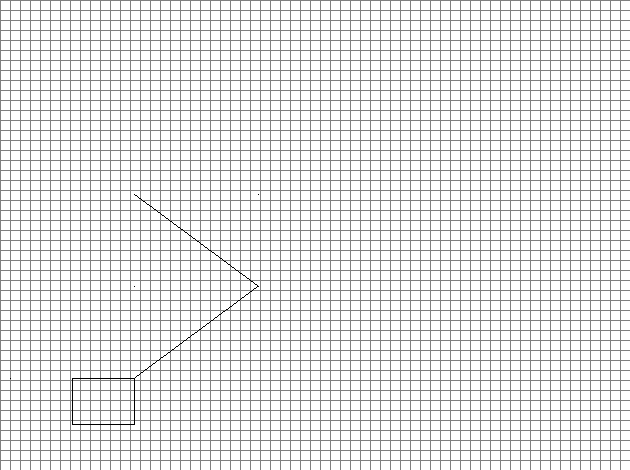

In [13]:
# Escrevendo os dados no arquivo de saída no formato XML
arquivo = open("saida.xml", "w")
arquivo.write("<?xml version=\"1.0\" ?>\n")
arquivo.write("<dados>\n")
margem_x = int(viewport[0].x)
margem_y = int(viewport[0].y)

for ponto in pontos:
    arquivo.write("    <ponto x=\"" + str(ponto.x - margem_x) + "\" y=\"" + str(ponto.y - margem_y) + "\"/>\n")


for reta in retas:
    arquivo.write("\n")
    arquivo.write("    <reta>\n")
    arquivo.write("        <ponto x1=\"" + str(reta.ponto1.x - margem_x) + "\" y1=\"" + str(reta.ponto1.y - margem_y) + "\"/>\n")
    arquivo.write("        <ponto x1=\"" + str(reta.ponto2.x - margem_x) + "\" y1=\"" + str(reta.ponto2.y - margem_y) + "\"/>\n")

    arquivo.write("    </reta>\n")
arquivo.write("\n")

arquivo.write("    <poligono>\n")
for ponto in poligono:
    arquivo.write("        <ponto x=\"" + str(int(ponto.x) - int(margem_x)) + "\" y=\"" + str(int(ponto.y) - int(margem_y)) + "\"/>\n")
arquivo.write("    </poligono>\n")
arquivo.write("</dados>")
arquivo.close()

# Criando e exibindo a janela da aplicação gráfica
app = QtWidgets.QApplication(sys.argv)
#window = MainWindow(pontos, retas, poligono, int(window[1].x) - int(window[0].x), int(window[1].y) - int(window[0].y))
window = MainWindow(pontos, retas, poligono, int(window[1].x) - int(window[0].x), int(window[1].y) - int(window[0].y))

window.show()
app.exec()

# Salvando a imagem resultante
nome_arquivo_imagem = "imagem_resultado.png"
salvar_imagem(window, nome_arquivo_imagem)
print("Imagem salva como:", nome_arquivo_imagem)

# Caminho da imagem salva
caminho_imagem = "imagem_resultado.png"

# Exibindo a imagem no notebook
Image(filename=caminho_imagem)

6. **Geração do arquivo de saída:** Um novo arquivo XML, chamado "saida.xml", deve ser gerado com os dados dos objetos no sistema de coordenadas da viewport, seguindo a mesma estrutura do arquivo de entrada.

Arquivo de saída resultante:

<?xml version="1.0" ?>
<dados>
    <ponto x="0.0" y="368.0"/>
    <ponto x="124.0" y="276.0"/>
    <ponto x="248.0" y="184.0"/>

    <reta>
        <ponto x1="124.0" y1="368.0"/>
        <ponto x1="248.0" y1="276.0"/>
    </reta>

    <reta>
        <ponto x1="248.0" y1="276.0"/>
        <ponto x1="124.0" y1="184.0"/>
    </reta>

    <poligono>
        <ponto x="62" y="414"/>
        <ponto x="62" y="368"/>
        <ponto x="124" y="368"/>
        <ponto x="124" y="414"/>
    </poligono>
</dados>


## <center>Conclusão</center>

Este trabalho aborda conceitos fundamentais de processamento de dados geométricos, incluindo transformações de coordenadas e manipulação de interfaces gráficas em Python.